# **"Prediksi Umur Harapan Hidup Tahun 2021 Menggunakan Model Regresi Linier Sederhana dari Data Umur Harapan Hidup Tahun Sebelumnya"**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=fe60cd0a74f4eeaad83f770bbf4b45b0743ae0b0df8f22aa8627802cc6de9814
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# **Pengumpulan** **Data**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

In [ ]:
spark = SparkSession.builder.appName('Umur Harapan Hidup').getOrCreate()

In [ ]:
df = spark.read.csv('UHH.csv', header=True, inferSchema=True)

In [ ]:
#Menampilkan Schema Data
df.printSchema()

root
 |-- Provinsi/Kabupaten/Kota: string (nullable = true)
 |-- 2019: double (nullable = true)
 |-- 2020: double (nullable = true)



In [ ]:
df.show(10)

+-----------------------+-----+-----+
|Provinsi/Kabupaten/Kota| 2019| 2020|
+-----------------------+-----+-----+
|                   ACEH|69.87|69.93|
|               Simeulue|65.22|65.26|
|           Aceh Singkil|67.36|67.39|
|           Aceh Selatan|64.27|64.35|
|          Aceh Tenggara|68.04|68.14|
|             Aceh Timur|68.67|68.72|
|            Aceh Tengah|68.82|68.85|
|             Aceh Barat|67.93|67.98|
|             Aceh Besar|69.77|69.78|
|                  Pidie|66.89|66.94|
+-----------------------+-----+-----+
only showing top 10 rows



# **Pembuatan Struktur Data yang Tepat**

In [ ]:
from pyspark.sql.functions import col

# Transposisi data
df_transposed = df.select(col("Provinsi/Kabupaten/Kota"),
                         col("2019").alias("umur_harapan_hidup_2019"),
                         col("2020").alias("umur_harapan_hidup_2020"))


# **Preprocessing Data**

In [ ]:
# Menghapus baris dengan nilai null atau tidak valid
df_cleaned = df_transposed.na.drop()

# Memilih fitur dan label
features_col = ["umur_harapan_hidup_2019"]
label_col = "umur_harapan_hidup_2020"


# **Analisis Eksplorasi**

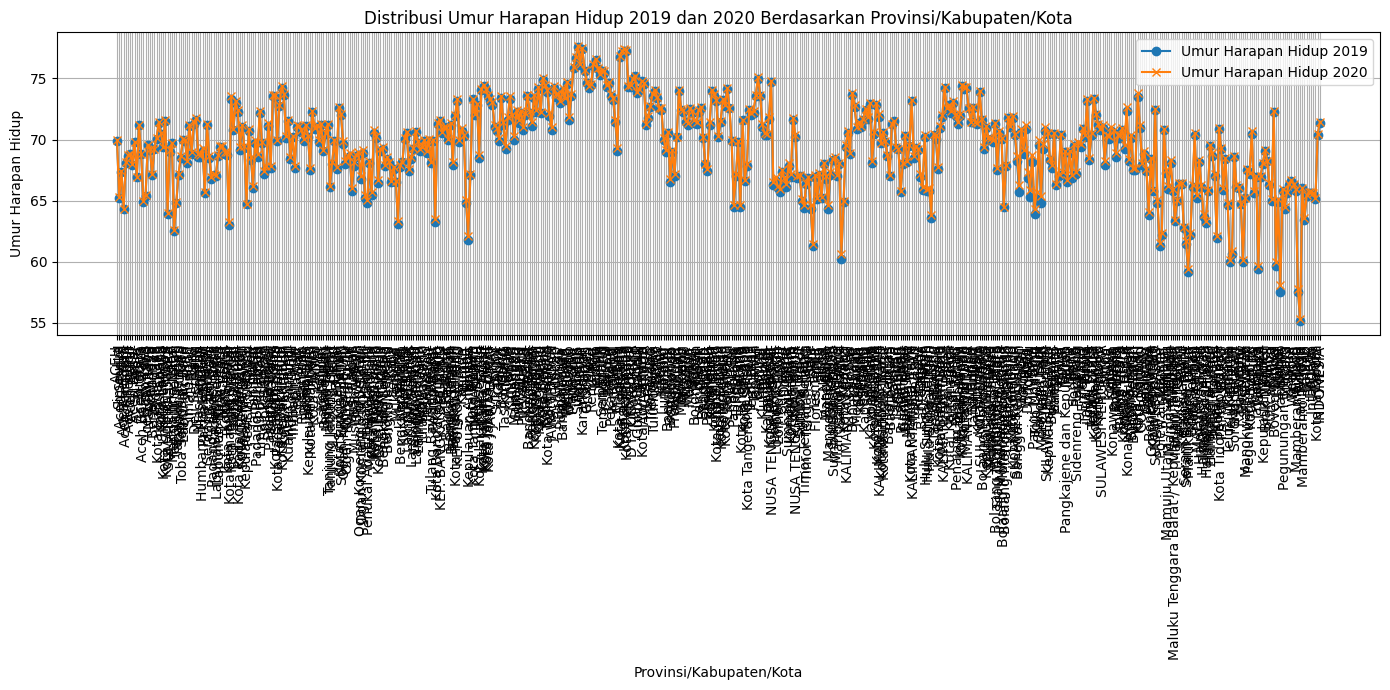

In [ ]:
import matplotlib.pyplot as plt

# Ambil data yang diperlukan
data_to_plot = df_cleaned.select("Provinsi/Kabupaten/Kota", "umur_harapan_hidup_2019", "umur_harapan_hidup_2020").collect()

# Persiapan data untuk plotting
provinces = [row[0] for row in data_to_plot]
life_expectancy_2019 = [row[1] for row in data_to_plot]
life_expectancy_2020 = [row[2] for row in data_to_plot]

# Buat visualisasi dengan diagram garis
plt.figure(figsize=(14, 7))

# Plot untuk umur harapan hidup 2019
plt.plot(provinces, life_expectancy_2019, label='Umur Harapan Hidup 2019', marker='o')

# Plot untuk umur harapan hidup 2020
plt.plot(provinces, life_expectancy_2020, label='Umur Harapan Hidup 2020', marker='x')

# Judul dan label sumbu
plt.title('Distribusi Umur Harapan Hidup 2019 dan 2020 Berdasarkan Provinsi/Kabupaten/Kota')
plt.xlabel('Provinsi/Kabupaten/Kota')
plt.ylabel('Umur Harapan Hidup')
plt.xticks(rotation=90)  # Rotasi label sumbu x untuk menghindari tumpang tindih
plt.grid(True)

# Tampilkan legenda
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import functions as F

# Hitung rata-rata Umur Harapan Hidup untuk tahun 2019 dan 2020
df_avg_combined = df.groupBy("Provinsi/Kabupaten/Kota").agg(
    ((F.avg("2019") + F.avg("2020")) / 2).alias("avg_combined")
).orderBy(F.desc("avg_combined")).limit(3)  # Ambil 3 daerah tertinggi berdasarkan rata-rata gabungan

# Tampilkan hasil gabungan untuk tahun 2019-2020
print("Daerah dengan rata-rata Umur Harapan Hidup tertinggi untuk tahun 2019-2020:")
for row in df_avg_combined.collect():
    print(f"{row['Provinsi/Kabupaten/Kota']}: {row['avg_combined']:.2f}")


Daerah dengan rata-rata Umur Harapan Hidup tertinggi untuk tahun 2019-2020:
Sukoharjo: 77.60
Karanganyar: 77.42
Kota Salatiga: 77.31


In [ ]:
# Hitung rata-rata Umur Harapan Hidup untuk tahun 2019 dan 2020
df_avg_combined = df.groupBy("Provinsi/Kabupaten/Kota").agg(
    ((F.avg("2019") + F.avg("2020")) / 2).alias("avg_combined")
).orderBy("avg_combined").limit(3)  # Ambil 3 daerah terendah berdasarkan rata-rata gabungan

# Tampilkan hasil gabungan untuk tahun 2019-2020
print("Daerah dengan rata-rata Umur Harapan Hidup terendah untuk tahun 2019-2020:")
for row in df_avg_combined.collect():
    print(f"{row['Provinsi/Kabupaten/Kota']}: {row['avg_combined']:.2f}")


Daerah dengan rata-rata Umur Harapan Hidup terendah untuk tahun 2019-2020:
Nduga: 55.20
Mamberamo Raya: 57.66
Asmat: 57.79


# **Pembuatan Model Regresi Linier**

In [ ]:
# Bagi data menjadi train dan test
train_data, test_data = df_cleaned.randomSplit([0.8, 0.2])


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Buat VectorAssembler untuk test_data
assembler_test = VectorAssembler(inputCols=["umur_harapan_hidup_2019"], outputCol="features")

# Transformasi data test dengan VectorAssembler
test_data_assembled = assembler_test.transform(test_data)

# Periksa schema dari test_data_assembled
test_data_assembled.printSchema()


root
 |-- Provinsi/Kabupaten/Kota: string (nullable = true)
 |-- umur_harapan_hidup_2019: double (nullable = true)
 |-- umur_harapan_hidup_2020: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler

# Buat VectorAssembler
assembler = VectorAssembler(inputCols=["umur_harapan_hidup_2019"], outputCol="features")

# Transformasi data train dengan VectorAssembler
train_data_assembled = assembler.transform(train_data)


In [ ]:
from pyspark.ml.regression import LinearRegression

# Inisiasi model regresi linier
lr = LinearRegression(featuresCol="features", labelCol="umur_harapan_hidup_2020")

# Latih model pada train_data_assembled
lr_model = lr.fit(train_data_assembled)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Prediksi menggunakan model yang sudah dilatih
predictions = lr_model.transform(test_data_assembled)

# Evaluasi model
evaluator = RegressionEvaluator(labelCol="umur_harapan_hidup_2020", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")


Root Mean Squared Error (RMSE) on test data: 0.08915509319870943


# **Prediksi**

In [ ]:
# Buat VectorAssembler
assembler_2021 = VectorAssembler(inputCols=["umur_harapan_hidup_2019"], outputCol="features")

# Transformasi data yang memilih kolom 2021 dengan VectorAssembler
df_2021_assembled = assembler_2021.transform(df_cleaned.select("Provinsi/Kabupaten/Kota","umur_harapan_hidup_2019","umur_harapan_hidup_2020"))

# Prediksi umur harapan hidup untuk tahun 2021
predictions_2021 = lr_model.transform(df_2021_assembled)

# Tampilkan prediksi
predictions_2021.show()


+-----------------------+-----------------------+-----------------------+--------+-----------------+
|Provinsi/Kabupaten/Kota|umur_harapan_hidup_2019|umur_harapan_hidup_2020|features|       prediction|
+-----------------------+-----------------------+-----------------------+--------+-----------------+
|                   ACEH|                  69.87|                  69.93| [69.87]|70.01696444034636|
|               Simeulue|                  65.22|                  65.26| [65.22]|65.39986257794153|
|           Aceh Singkil|                  67.36|                  67.39| [67.36]|67.52472235977945|
|           Aceh Selatan|                  64.27|                  64.35| [64.27]|64.45658370282658|
|          Aceh Tenggara|                  68.04|                  68.14| [68.04]|68.19991144933543|
|             Aceh Timur|                  68.67|                  68.72| [68.67]| 68.8254542823064|
|            Aceh Tengah|                  68.82|                  68.85| [68.82]|68.974393

# **Interpretasi Hasil**

In [ ]:
# Koefisien model
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")


Coefficients: [0.9929251316999581]
Intercept: 0.6412854884702713


In [ ]:
predictions_2021.cache()


DataFrame[Provinsi/Kabupaten/Kota: string, umur_harapan_hidup_2019: double, umur_harapan_hidup_2020: double, features: vector, prediction: double]

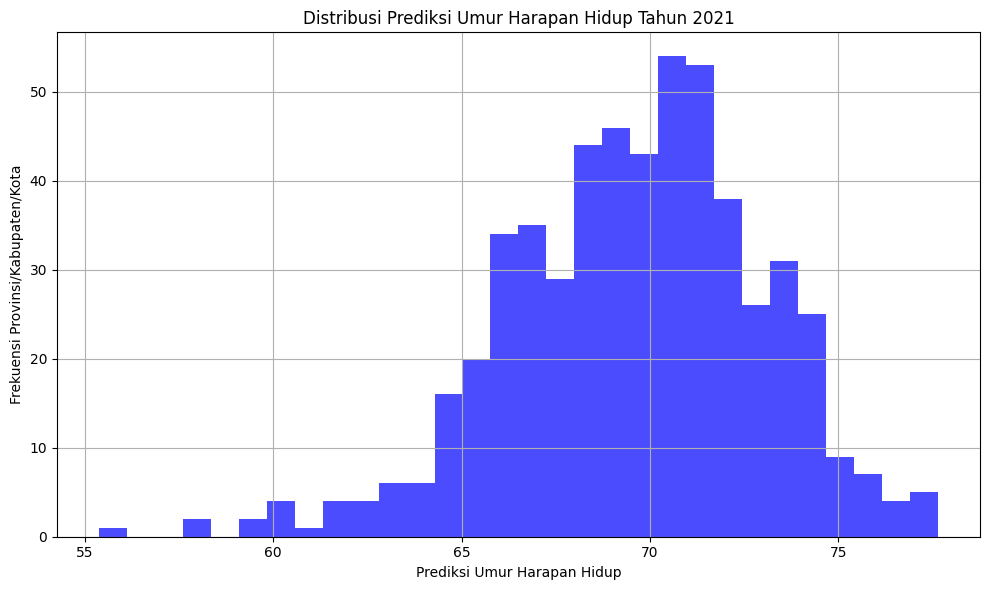

In [ ]:
import matplotlib.pyplot as plt

# Ambil prediksi dari DataFrame ke dalam list
predicted_values = predictions_2021.select("prediction").rdd.flatMap(lambda x: x).collect()

# actual_values = predictions_2021.select("umur_harapan_hidup_2021").rdd.flatMap(lambda x: x).collect()

# Melihat distribusi prediksi menggunakan histogram
plt.figure(figsize=(10, 6))
plt.hist(predicted_values, bins=30, color='blue', alpha=0.7)
plt.title('Distribusi Prediksi Umur Harapan Hidup Tahun 2021')
plt.xlabel('Prediksi Umur Harapan Hidup')
plt.ylabel('Frekuensi Provinsi/Kabupaten/Kota')
plt.grid(True)
plt.tight_layout()

# Tampilkan plot
plt.show()


In [ ]:
# Rata-rata prediksi umur harapan hidup tahun 2021
rata_rata_prediksi_2021 = predictions_2021.agg({"prediction": "avg"}).collect()[0][0]

print(f"Rata-rata prediksi umur harapan hidup untuk tahun 2021 adalah: {rata_rata_prediksi_2021:.2f}")


Rata-rata prediksi umur harapan hidup untuk tahun 2021 adalah: 69.58


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Inisialisasi evaluator dengan labelCol yang sesuai
evaluator_rmse = RegressionEvaluator(labelCol="umur_harapan_hidup_2020", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="umur_harapan_hidup_2020", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="umur_harapan_hidup_2020", predictionCol="prediction", metricName="r2")

# Hitung RMSE
rmse = evaluator_rmse.evaluate(predictions_2021)
print(f"Root Mean Squared Error (RMSE) untuk prediksi tahun 2021: {rmse:.4f}")

# Hitung MAE
mae = evaluator_mae.evaluate(predictions_2021)
print(f"Mean Absolute Error (MAE) untuk prediksi tahun 2021: {mae:.4f}")

# Hitung R^2
r2 = evaluator_r2.evaluate(predictions_2021)
print(f"Coefficient of Determination (R^2) untuk prediksi tahun 2021: {r2:.4f}")



Root Mean Squared Error (RMSE) untuk prediksi tahun 2021: 0.0828
Mean Absolute Error (MAE) untuk prediksi tahun 2021: 0.0598
Coefficient of Determination (R^2) untuk prediksi tahun 2021: 0.9994


In [ ]:
print(df.columns)


['Provinsi/Kabupaten/Kota', '2019', '2020']


# **Perbandingan Umur Harapan Hidup Dari Tahun ke Tahun**

In [ ]:
# Membaca data dari file CSV
df_actual = spark.read.csv('UHH.csv', header=True, inferSchema=True)

# Menggunakan kolom yang relevan untuk tahun 2019 dan 2020
actual_values_2019 = df_actual.select("2019").rdd.flatMap(lambda x: x).collect()
actual_values_2020 = df_actual.select("2020").rdd.flatMap(lambda x: x).collect()



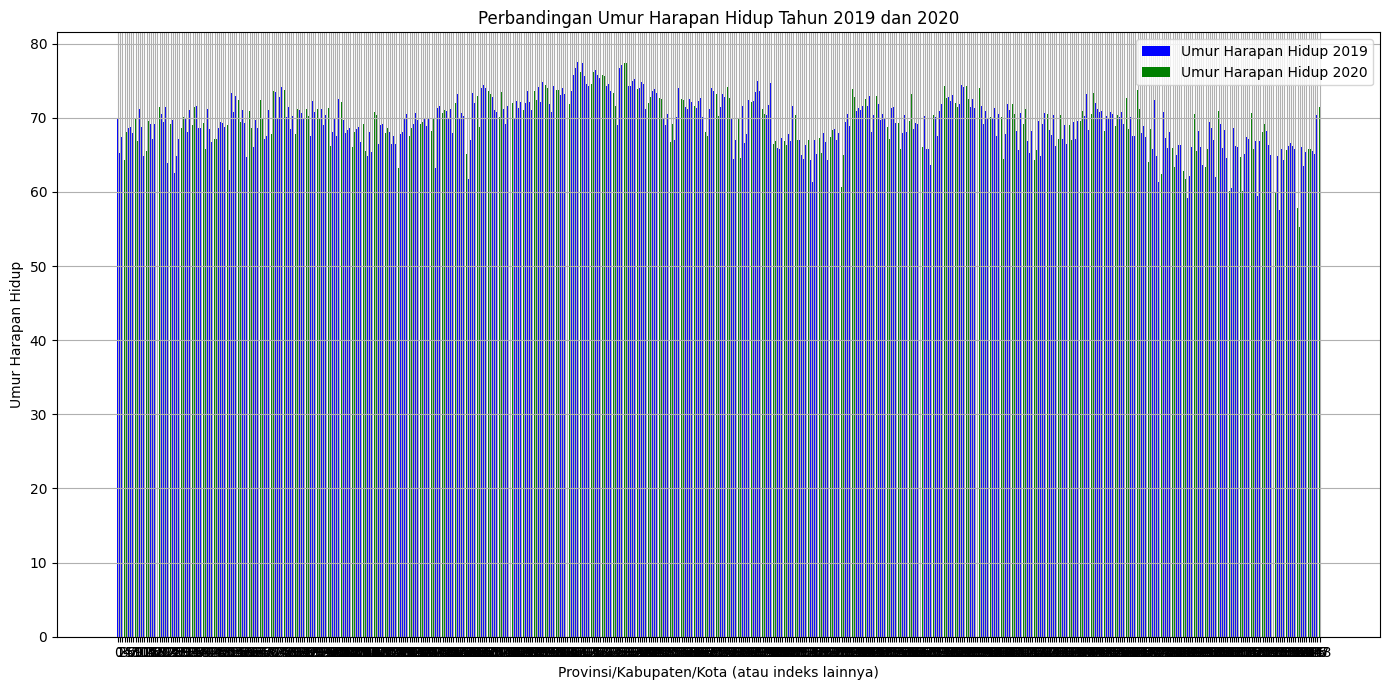

In [ ]:
import matplotlib.pyplot as plt

# Data aktual untuk tahun 2019 dan 2020
actual_values_2019 = df_actual.select("2019").rdd.flatMap(lambda x: x).collect()
actual_values_2020 = df_actual.select("2020").rdd.flatMap(lambda x: x).collect()

# Daftar Provinsi/Kabupaten/Kota atau indeks lainnya
labels = range(len(actual_values_2019))

# Visualisasi dengan diagram batang
plt.figure(figsize=(14, 7))

# Plot untuk umur harapan hidup tahun 2019
plt.bar(labels, actual_values_2019, width=0.3, align='center', label='Umur Harapan Hidup 2019', color='blue')

# Plot untuk umur harapan hidup tahun 2020
plt.bar([i + 0.3 for i in labels], actual_values_2020, width=0.3, align='center', label='Umur Harapan Hidup 2020', color='green')

# Judul dan label sumbu
plt.title('Perbandingan Umur Harapan Hidup Tahun 2019 dan 2020')
plt.xlabel('Provinsi/Kabupaten/Kota (atau indeks lainnya)')
plt.ylabel('Umur Harapan Hidup')
plt.xticks([i + 0.3 for i in labels], labels)  # Untuk menambahkan label pada sumbu x
plt.grid(True)

# Tampilkan legenda
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()


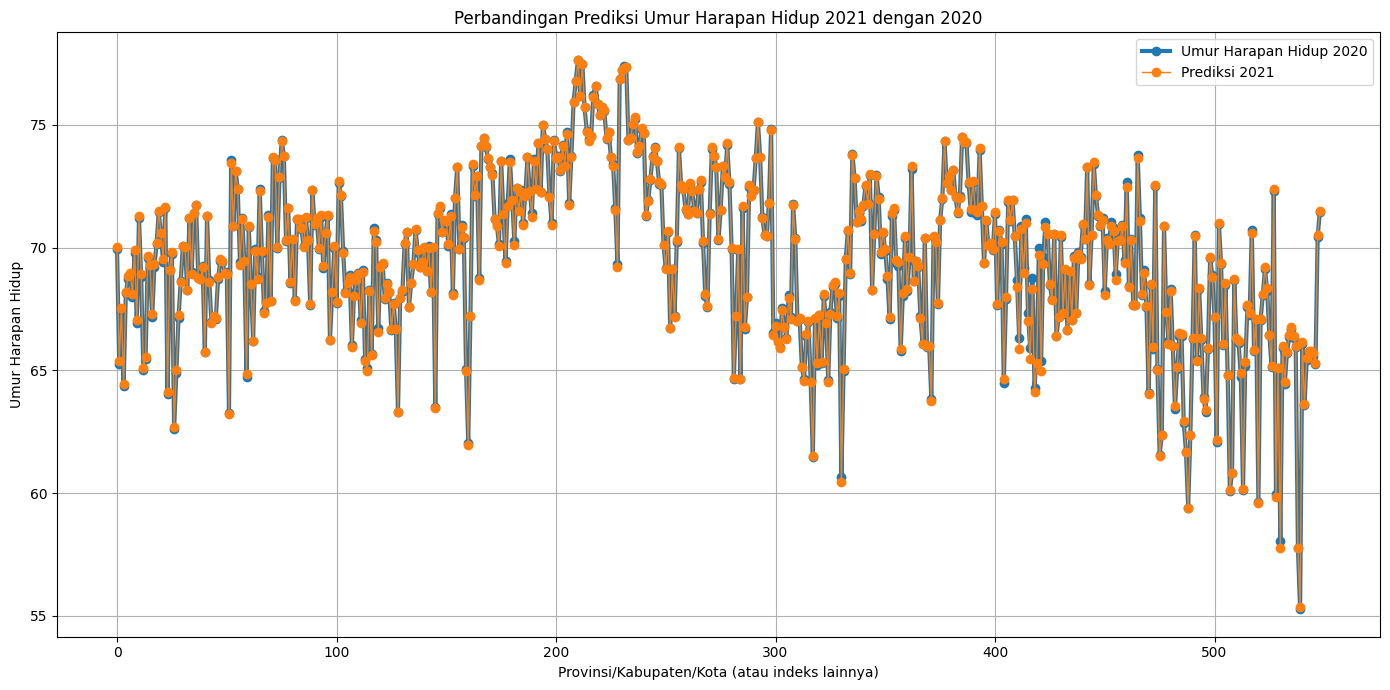

In [ ]:
import matplotlib.pyplot as plt

# Ambil prediksi untuk tahun 2021
predicted_values_2021 = predictions_2021.select("prediction").rdd.flatMap(lambda x: x).collect()

# Data aktual untuk tahun 2020 dalam list berikut
actual_values_2020 = df_actual.select("2020").rdd.flatMap(lambda x: x).collect()

# Buat visualisasi dengan diagram garis
plt.figure(figsize=(14, 7))

# Plot untuk actual 2020
plt.plot(actual_values_2020, label='Umur Harapan Hidup 2020', marker='o', linewidth=3)
# Plot untuk prediksi 2021
plt.plot(predicted_values_2021, label='Prediksi 2021', marker='o', linewidth=1)

# Judul dan label sumbu
plt.title('Perbandingan Prediksi Umur Harapan Hidup 2021 dengan 2020')
plt.xlabel('Provinsi/Kabupaten/Kota (atau indeks lainnya)')
plt.ylabel('Umur Harapan Hidup')
plt.grid(True)

# Tampilkan legenda
plt.legend()

# Tampilkan plot
plt.tight_layout()
plt.show()
